<a href="https://colab.research.google.com/github/Bakarime27/app-sante-public/blob/main/exploration_data_asp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concevoir une application au service de la santé publique**
Ce projet consiste à traiter les données **Open Food Facts** tout en ayant à l'idée de proposer une application qui répond à un appel à projet de la santé publique.

### **1.&nbsp;Description du dataset**
Le dataset contient la liste de plus de 300000 produits avec leurs ingrédients et les valeurs calorifiques et nutritionnelles.



*   Les colonnes qui se terminent en _t sont les dates sous le format unix timestamp
*   Les colonnes qui se terminent en _datetime sont les dates sous le format iso8601
*   Les colonnes qui se terminent en _100g correspondent à la quantité de nutriments contenue dans 100g ou 100ml de produit
*   Les colonnes qui se terminent avec _serving correspondent à la quantité de nutriments contenue dans une portion de produit 
*   nutrition-score-fr_100g correspond au score nutritionnel d'un produit variant de -15 à 40, plus bas est le score plus le produit est sain
*   nutrition_grade_fr_100g correspond à une simple catégorisation du nutriscore, les valeurs allant de A jusqu'à E

### **2.&nbsp;Exploration des données**

In [1]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
clean-data.csv  fr.openfoodfacts.org.products.csv


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('clean-data.csv', sep='\t', low_memory=False)

In [4]:
print(f'Le dataset contient {df.shape[0]} lignes et {df.shape[1]} colonnes')

Le dataset contient 30200 lignes et 29 colonnes


### **2.1.&nbsp;Analyse univariée**


### **2.1.1.&nbsp;Répartition des nutrigrades et nutriscores**

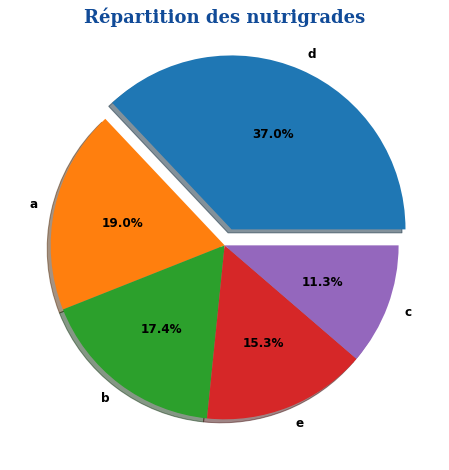

In [5]:
#Répartition des nutrigrades par le camembert
nutrigrade = df.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
           
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

explodes = np.zeros(5)
explodes[0] = .1

plt.pie(nutrigrade, labels=nutrigrade.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
plt.title("Répartition des nutrigrades", fontdict=font_title)
plt.show()

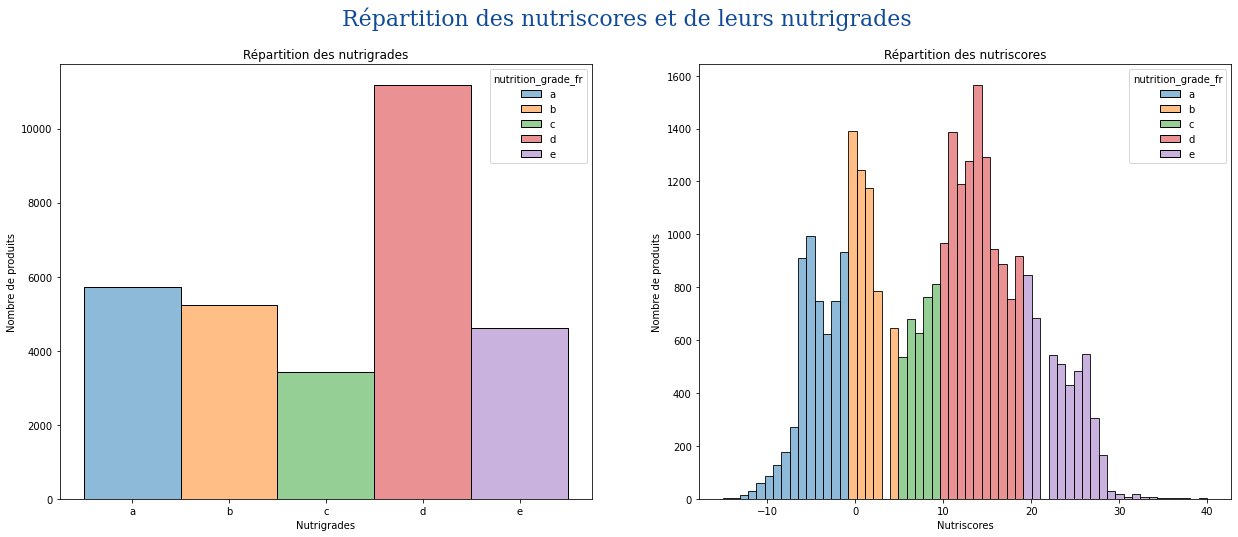

In [6]:
#Répartition des nutriscores et nutrigrades
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des nutriscores et de leurs nutrigrades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=df.sort_values("nutrition_grade_fr"), x="nutrition_grade_fr", hue="nutrition_grade_fr", ax=axes[0])
axes[0].set_title('Répartition des nutrigrades')
axes[0].set_xlabel("Nutrigrades")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=df.sort_values("nutrition_grade_fr"), x="nutrition-score-fr_100g", hue="nutrition_grade_fr", ax=axes[1])
axes[1].set_title('Répartition des nutriscores')
axes[1].set_xlabel("Nutriscores")
axes[1].set_ylabel("Nombre de produits")

plt.show()

### **2.1.2.&nbsp;Répartition du taux de sucre**



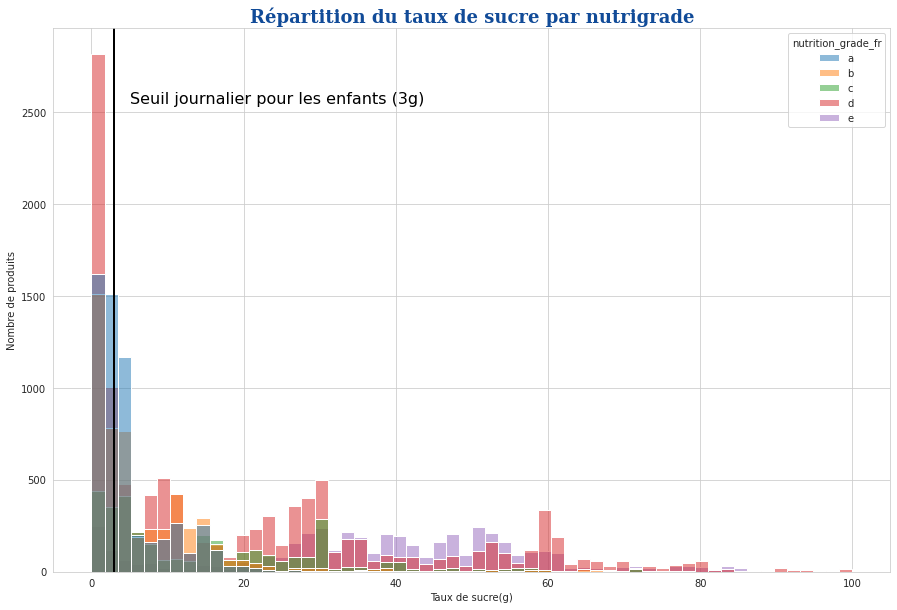

In [44]:
#Nous allons analyser la distribution du taux de sucre
#taux_de_sucre = df[['sugars_100g']]

fig=plt.figure(figsize=(15,10))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
seuil_sucre = 3
sns.set_style("whitegrid")
sns.histplot(data=df.sort_values("nutrition_grade_fr"), x='sugars_100g', hue="nutrition_grade_fr", color='#00afe6')
plt.axvline(x=seuil_sucre, linewidth=2, color = 'black')
plt.text(seuil_sucre+2, 2550, 'Seuil journalier pour les enfants (3g)', fontsize = 16, color = 'black')

plt.title("Répartition du taux de sucre par nutrigrade", fontdict=font_title)
plt.xlabel("Taux de sucre(g)")
plt.ylabel("Nombre de produits")
plt.show()


Nous pouvons dire la majeur partie des produits ont un taux de sucre inférieur à 12g (le seuil recommandé pour les enfants)

Afin de vérifier si la catégorie pnns_groups_1 influence rééllement le taux de sucre, nous pouvons réaliser une ANOVA (Analyse de la variance). 

Les hypothèses posées seront donc les suivantes :

*  H0 : La distribution des échantillons est similaire (et donc la catégorie n'a aucune influence sur le taux de sucre).
*  H1 : Une ou plusieurs distributions sont inégales.  

Pour commencer, nous pouvons projeter les boxplots de la répartition du taux de sucre par catégorie pnns_groups_1 pour également vérifier les hypothèses de départ liées à l'ANOVA à savoir :

*  Les observations dans chaque échantillon sont indépendantes et distribuées de manière identique (iid).
*  Les observations de chaque échantillon sont normalement distribuées.

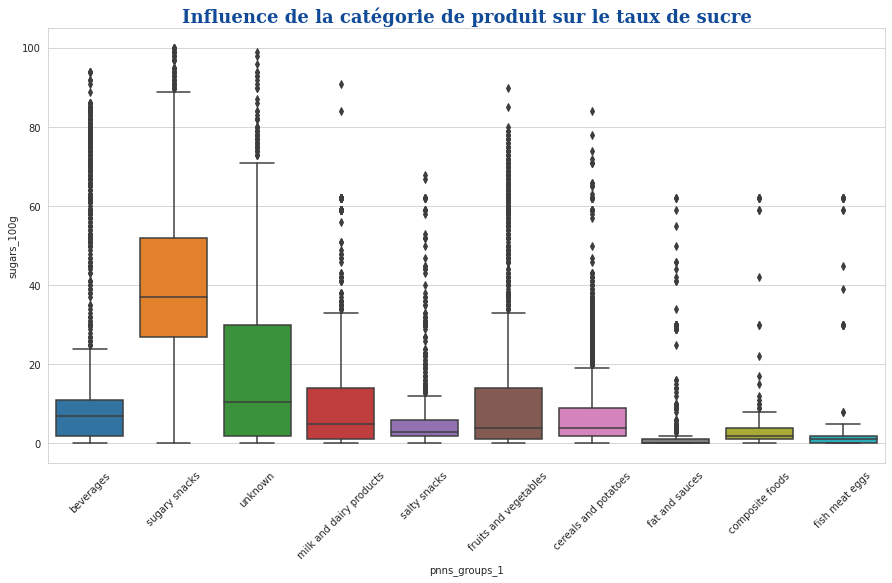

In [13]:
fig = plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df, x='pnns_groups_1', y='sugars_100g')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le taux de sucre", fontdict=font_title)
plt.show()

Nous voyons que les catégories sont plutôt différentes, les distributions ne semnlent pas suivre la loi normale.

In [14]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

anova_category = smf.ols('sugars_100g~pnns_groups_1', data=df).fit()
print(anova_category.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:            sugars_100g   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     2244.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        09:38:23   Log-Likelihood:            -1.2592e+05
No. Observations:               30200   AIC:                         2.519e+05
Df Residuals:                   30190   BIC:                         2.519e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [15]:
#Tableau d'analyse de variance
sm.stats.anova_lm(anova_category, typ=2)

,sum_sq,df,F,PR(>F)
pnns_groups_1,4.949578e+06,9.0,2244.140199,0.0
Residual,7.398416e+06,30190.0,NaN,NaN


Les résultats du test de Fisher nous indiquent ici une p-value très proche de 0 pour l'ensemble des catégories, donc inferieur au niveau de test de 5%.  
Nous rejettons donc l'hypothèse H0 selon laquelle les ditributions sont identiques.  
La catégorie de produit a donc bien une influence sur le taux de sucre.

### **2.2.&nbsp;Analyse multivariée**


### **2.2.1.&nbsp;Corrélations linéaires**


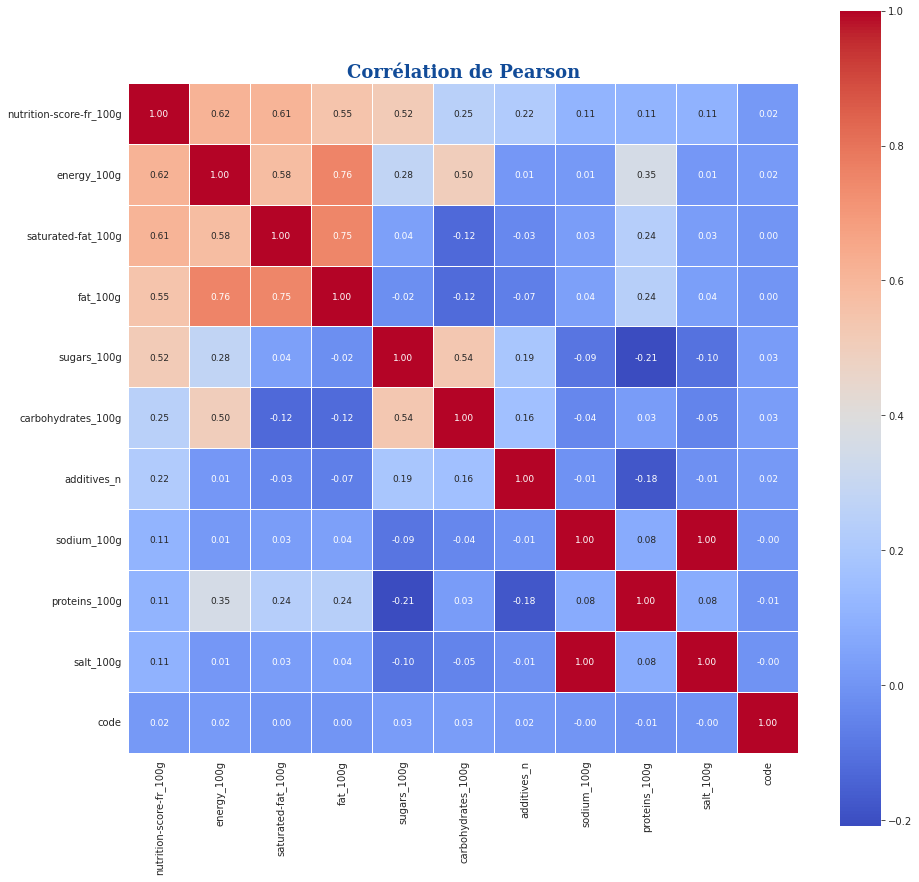

In [28]:
#Matrice des corrélations
corr_mat = df.corr()
cols = corr_mat.nlargest(11,'nutrition-score-fr_100g')['nutrition-score-fr_100g'].index
corr_nutriscore = corr_mat.loc[cols, cols]
#heatmap
fig = plt.figure(figsize=(15,15))
sns.heatmap(corr_nutriscore, cbar=True, fmt='.2f', annot_kws={'size': 9}, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Corrélation de Pearson", fontdict=font_title)
plt.show()

### **2.2.2.&nbsp;Analyse en composantes principales (PCA)**

**Eboulis des valeurs propres**

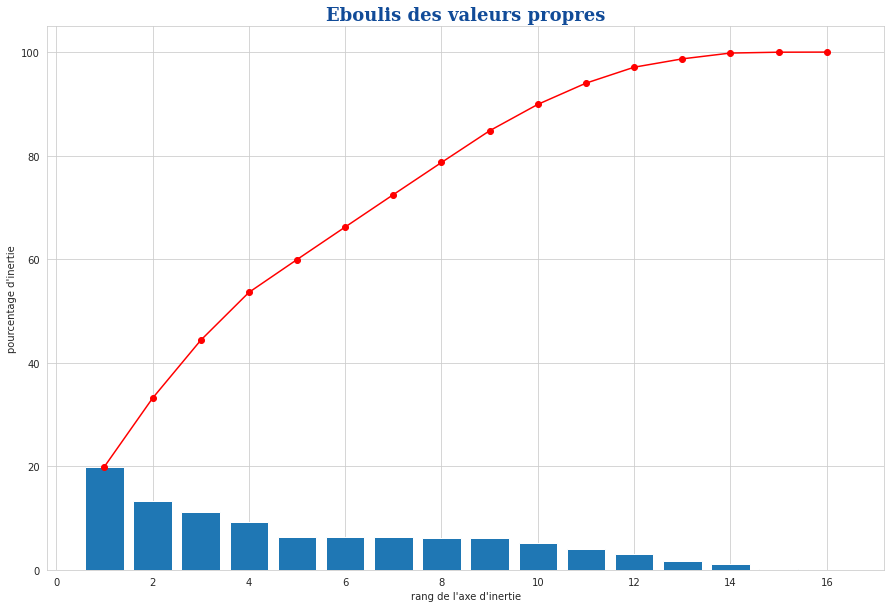

In [30]:
#Variances expliquées
variances_expliquees = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(15,10))
plt.bar(np.arange(len(variances_expliquees))+1, variances_expliquees)
plt.plot(np.arange(len(variances_expliquees))+1, variances_expliquees.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", fontdict=font_title)
plt.show(block=False)

**Cercle des corrélations**

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#standardisation
X = df.select_dtypes(include=['float64','int64'])
X_standard = scaler.fit_transform(X)

#Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_standard)
X_projecte = pca.transform(X_standard)

In [32]:
#Espace des composantes principales
pcs = pca.components_

#Matrice des corrélations variables x facteurs
p = X.shape[1]
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((p, p))
for dim in range(p):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

#on affiche pour les deux premiers plans factoriels 
corr_matrix = pd.DataFrame({'feature':X.columns,'CORR_F1':corvar[:,0],'CORR_F2':corvar[:,1], 
              'CORR_F3':corvar[:,2], 'CORR_F4':corvar[:,3]})
corr_matrix

,feature,CORR_F1,CORR_F2,CORR_F3,CORR_F4
0,code,0.024814,-0.034844,0.051781,0.018338
1,energy_100g,0.912705,-0.100916,-0.029350,0.232342
2,proteins_100g,0.349566,0.277866,-0.332963,0.493303
3,salt_100g,0.109113,0.832303,0.538631,0.034693
4,sodium_100g,0.112816,0.827466,0.544910,0.031355
5,additives_n,0.069391,-0.257557,0.424355,-0.343576
6,sugars_100g,0.364491,-0.542363,0.554386,-0.032591
7,fat_100g,0.811727,0.175815,-0.371951,-0.173002
8,carbohydrates_100g,0.321475,-0.468745,0.538124,0.467854
9,saturated-fat_100g,0.777346,0.155213,-0.332602,-0.285035


In [33]:
#Variable Illustrative
ivNutrigrade = df['nutrition_grade_fr'].values

#Encodage des grades
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ivNutrigrade = encoder.fit_transform(ivNutrigrade)
ivNutrigrade = ivNutrigrade.reshape((ivNutrigrade.shape[0],1))

#Corrélation de la variable illustrative avec les axes factoriels 
corrIv = np.zeros((ivNutrigrade.shape[1],p))
for j in range(p): 
    for k in range(ivNutrigrade.shape[1]): 
        corrIv[k,j] = np.corrcoef(ivNutrigrade[:,k],X_projecte[:,j])[0,1]

In [34]:
def cercle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0, 
               illustrative_var_label=None, illustrative_var_corr=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box') 

            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                plt.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #variable illustrative
            if illustrative_var_label is not None :
                plt.annotate(illustrative_var_label,
                             (illustrative_var_corr[0,d1],illustrative_var_corr[0,d2]),
                             color='g')
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                                   illustrative_var_corr[0,d1],illustrative_var_corr[0,d2], 
                                   angles='xy', scale_units='xy', scale=1, color="g", alpha=0.5)

            #ajouter les axes 
            plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

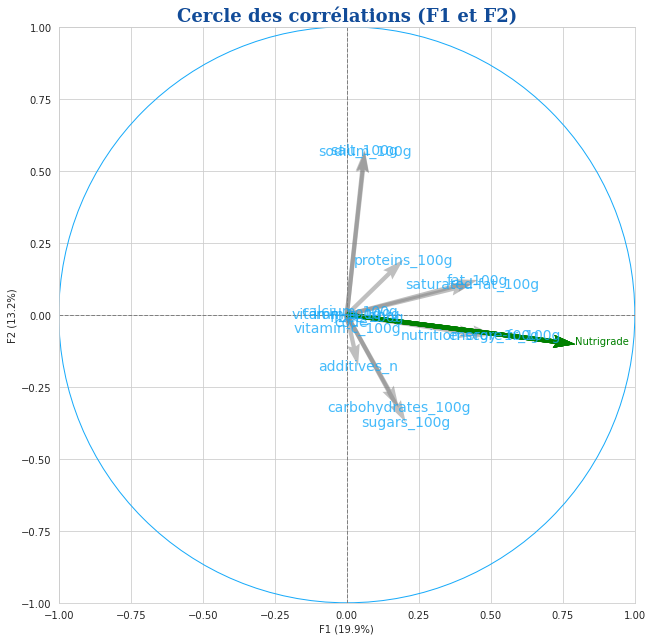

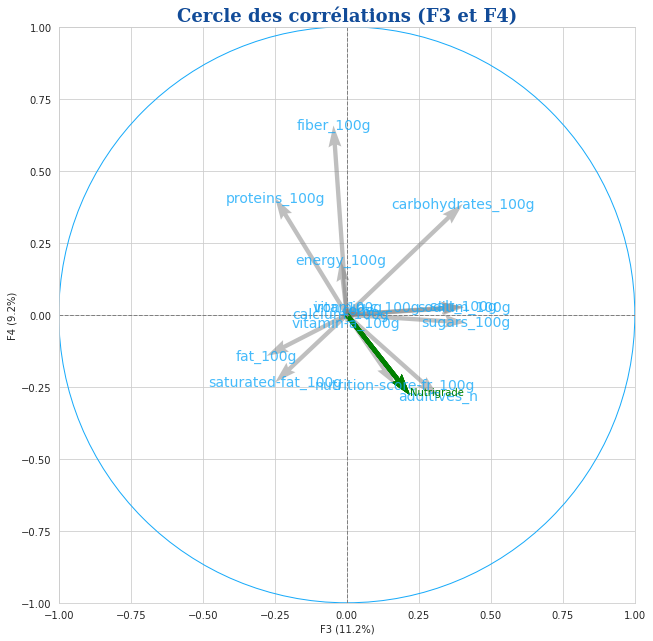

In [36]:
cercle_corr(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(X.columns), 
           illustrative_var_label="Nutrigrade", illustrative_var_corr = corrIv)

**Projection des produits sur les plans factoriels**

In [37]:
def graphe_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)

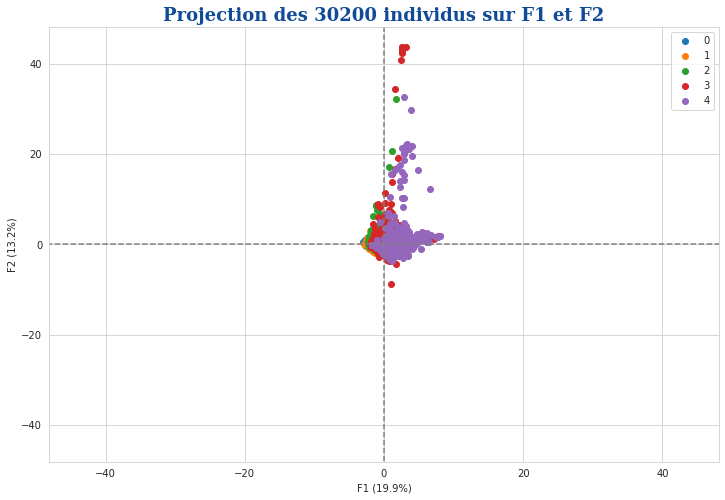

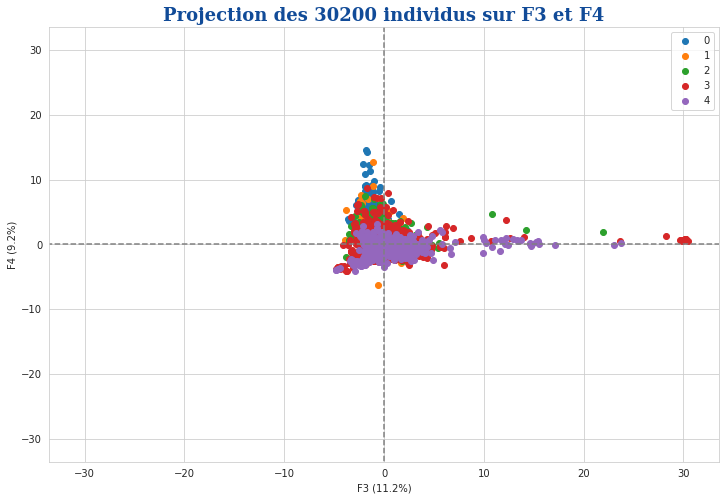

In [38]:
graphe_plans_factoriels(X_projecte, 4, pca, [(0,1),(2,3)], illustrative_var = ivNutrigrade)

**Calcul de COS² et CTR**

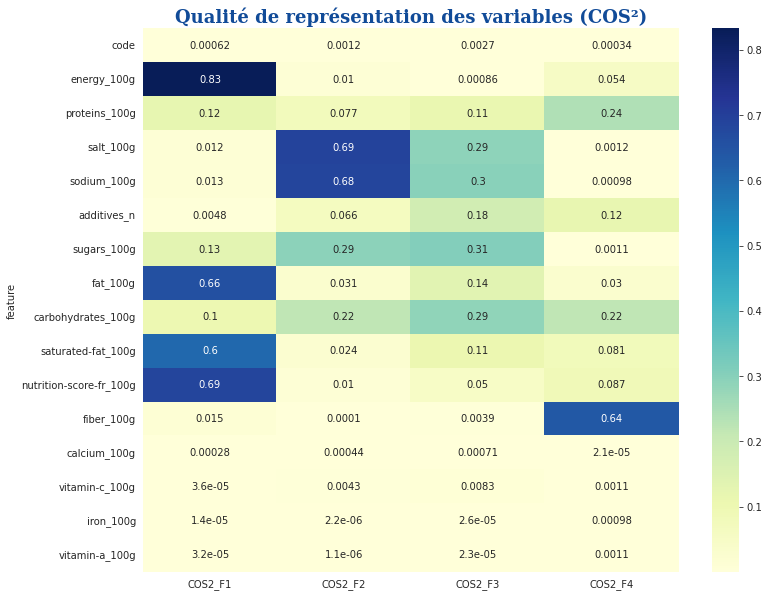

In [39]:
#Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':X.columns,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontdict=font_title)
plt.show()

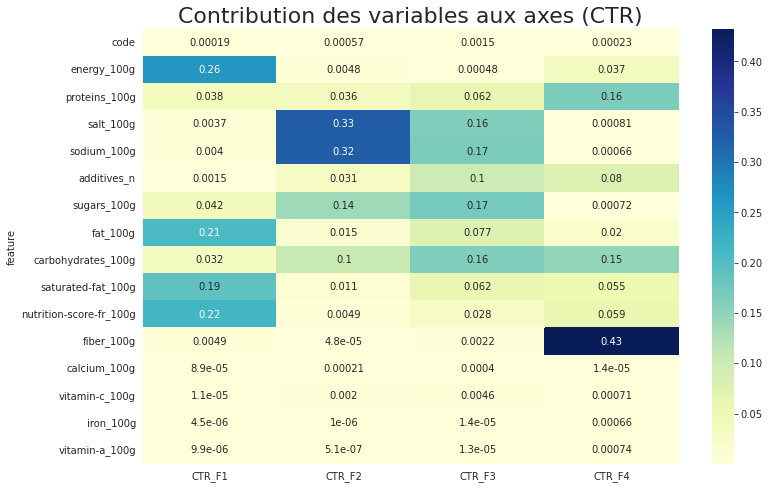

In [40]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':X.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.show()

**Proposition d'un nouveau score basé sur le taux de sucre**

In [45]:
def calcul_sucrigrade(row):
  if row["sugars_100g"] < 3 :
    sucrigrade = "x"
  elif ((row["sugars_100g"] >= 3) & (row["sugars_100g"] < 5)) :
    sucrigrade = "y"
  else:
    sucrigrade = "z"
  return sucrigrade

In [47]:
df['sucrigrade'] = df.apply(lambda row : calcul_sucrigrade(row), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code                     30200 non-null  int64  
 1   last_modified_datetime   30200 non-null  object 
 2   creator                  30200 non-null  object 
 3   created_datetime         30199 non-null  object 
 4   url                      30200 non-null  object 
 5   states_fr                30200 non-null  object 
 6   countries_fr             30200 non-null  object 
 7   product_name             30200 non-null  object 
 8   brands                   30200 non-null  object 
 9   energy_100g              30200 non-null  float64
 10  proteins_100g            30200 non-null  float64
 11  salt_100g                30200 non-null  float64
 12  sodium_100g              30200 non-null  float64
 13  additives_n              30200 non-null  float64
 14  sugars_100g           

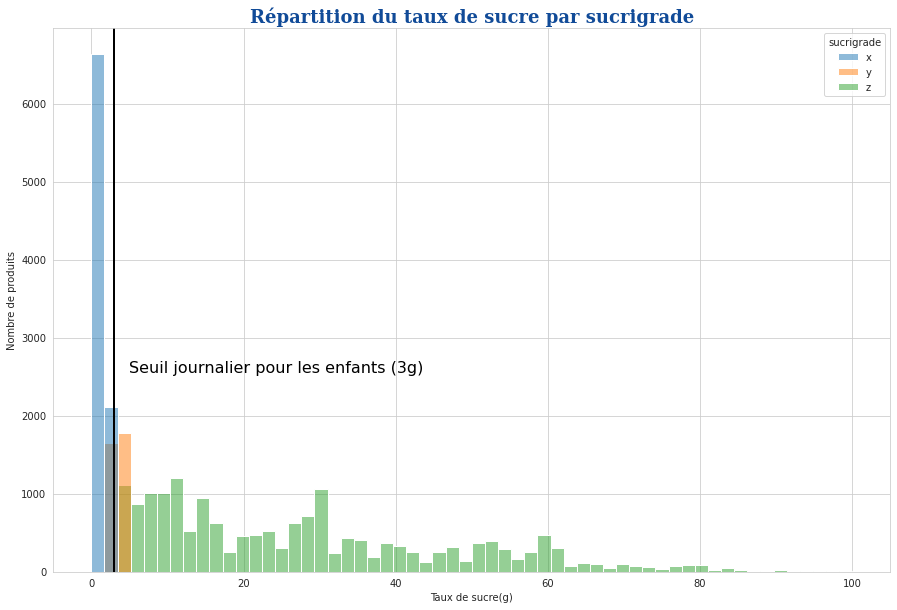

In [49]:
fig=plt.figure(figsize=(15,10))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }
seuil_sucre = 3
sns.set_style("whitegrid")
sns.histplot(data=df.sort_values("sucrigrade"), x='sugars_100g', hue="sucrigrade", color='#00afe6')
plt.axvline(x=seuil_sucre, linewidth=2, color = 'black')
plt.text(seuil_sucre+2, 2550, 'Seuil journalier pour les enfants (3g)', fontsize = 16, color = 'black')

plt.title("Répartition du taux de sucre par sucrigrade", fontdict=font_title)
plt.xlabel("Taux de sucre(g)")
plt.ylabel("Nombre de produits")
plt.show()